In [2]:
import os, sys
import recognition_digit,card_segmentation
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage.morphology import thin
from numpy import arange
from numpy import meshgrid

# 1. find king

In [3]:
file_list = card_segmentation.walkFile("../train_games")
file_pics=[]
print(file_list)
for file in file_list:
    if file.endswith('.jpg'):
        recognition_digit
        image = card_segmentation.read_image(file)
            
        print(file)    
        mask_t = card_segmentation.mask_thre(image)
        image = card_segmentation.mask_dealer(image)
        mask_r = card_segmentation.mask_range(image)
        labeled_array, num_features = ndimage.label(mask_t, structure = np.ones((3,3)))

        for i in range(num_features):
            if np.sum(mask_r[labeled_array == i+1]) < 255 * 600:
                mask_t[labeled_array == i+1] = 0
                
        mask = np.uint8(mask_t)

        players,centers,points_f,labels = card_segmentation.players_clustering(mask)
        cards,left_lowers,right_lowers,right_uppers = card_segmentation.find_corners(players,centers,image)
        for card in cards:
            recognition_digit.find_king(card)
            

['../train_games\\game1\\1.jpg', '../train_games\\game1\\10.jpg', '../train_games\\game1\\11.jpg', '../train_games\\game1\\12.jpg', '../train_games\\game1\\13.jpg', '../train_games\\game1\\2.jpg', '../train_games\\game1\\3.jpg', '../train_games\\game1\\4.jpg', '../train_games\\game1\\5.jpg', '../train_games\\game1\\6.jpg', '../train_games\\game1\\7.jpg', '../train_games\\game1\\8.jpg', '../train_games\\game1\\9.jpg', '../train_games\\game1\\game1.csv', '../train_games\\game2\\1.jpg', '../train_games\\game2\\10.jpg', '../train_games\\game2\\11.jpg', '../train_games\\game2\\12.jpg', '../train_games\\game2\\13.jpg', '../train_games\\game2\\2.jpg', '../train_games\\game2\\3.jpg', '../train_games\\game2\\4.jpg', '../train_games\\game2\\5.jpg', '../train_games\\game2\\6.jpg', '../train_games\\game2\\7.jpg', '../train_games\\game2\\8.jpg', '../train_games\\game2\\9.jpg', '../train_games\\game2\\game2.csv', '../train_games\\game3\\1.jpg', '../train_games\\game3\\10.jpg', '../train_games\\game3

C:\Users\zyysu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


../train_games\game1\10.jpg


C:\Users\zyysu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KeyboardInterrupt: 

# 2. differentiate 1 and J

['1_and_j\\10.jpg', '1_and_j\\11.jpg', '1_and_j\\12.jpg', '1_and_j\\13.jpg', '1_and_j\\14.jpg', '1_and_j\\15.jpg', '1_and_j\\16.jpg', '1_and_j\\17.jpg', '1_and_j\\J0.jpg', '1_and_j\\J1.jpg', '1_and_j\\J2.jpg', '1_and_j\\J3.jpg', '1_and_j\\J4.jpg', '1_and_j\\J5.jpg', '1_and_j\\J6.jpg', '1_and_j\\J7.jpg']


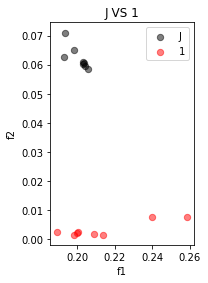

In [5]:
ones_im,Js_im = recognition_digit.load_1_J_training('1_and_j')
Js_thin,ones_thin = recognition_digit.thin_images(Js_im, ones_im)
o_J_0,o_J_1,o_1_0,o_1_1 = recognition_digit.plot_result(Js_thin, ones_thin,1,2)

plt.figure(figsize=(18, 9)) 

plt.subplot(2, 6, 1)
plt.scatter(o_J_0,o_J_1,marker='o', s=40, c='black', alpha=0.5, label = 'J')
plt.scatter(o_1_0,o_1_1,marker='o', s=40, c='red', alpha=0.5, label = '1')
plt.legend(loc = "upper right")
plt.xlabel('f1')
plt.ylabel('f2')
plt.title('J VS 1')
plt.show()

# 3. MD classifier

In [3]:
J_datas_temp = [[a,b] for a,b in zip(o_J_0, o_J_1)]
J_datas = np.asarray(J_datas_temp)

one_datas_temp = [[a,b] for a,b in zip(o_1_0, o_1_1)]
one_datas = np.asarray(one_datas_temp)


In [6]:
mu_J = np.mean (J_datas, axis = 0, dtype = None) 
mu_1 = np.mean (one_datas, axis = 0, dtype = None) 

# For simplicity reasons, we round the estimated covariant matrix to the closest integer value.
J_datas_t = np.array(J_datas).T
covMatrix_J = np.cov(J_datas_t,bias=True)


one_datas_t = np.array(one_datas).T
covMatrix_1 = np.cov(one_datas_t,bias=True)




# computation of inverse covariant matrix 
covMatrix_J_inv = np.linalg.inv(covMatrix_J)
covMatrix_1_inv = np.linalg.inv(covMatrix_1)

def classifer_MD(point_x, point_y,verbose = False):
    """
    Compute the MD of 1 point to 2 classes : class a and class b, 
    return which class this point belongs to
    arg:
      point_x: coordinate point on axis x
      point_y: coordinate point on axis y
      verbose: booleen for display of the answer (display if 'True', otherwise thw answer will not be displaced) 
    
    """
    point=np.matrix([point_x,point_y])

    dist_to_J = np.sqrt((point-mu_J)*covMatrix_J_inv*np.transpose(point-mu_J))
    dist_to_1 = np.sqrt((point-mu_1)*covMatrix_1_inv*np.transpose(point-mu_1))

    dist_to_J = float(dist_to_J)
    dist_to_1 = float(dist_to_1)
    
    print(dist_to_J,dist_to_1)
    if verbose == True:
        if dist_to_J <= dist_to_1:
            print("point({0},{1}) belongs to class J".format(point_x,point_y))
        else:
            print("point({0},{1}) belongs to class 1".format(point_x,point_y))


def classifer_MD_find_line():
    """
    Find and plot the separation curve between class a and class b
    """
    mJ1=mu_J[0];
    mJ2=mu_J[1];
    
    m11=mu_1[0];
    m12=mu_1[1];
    

    J_inv11=covMatrix_J_inv[0][0]
    J_inv12=covMatrix_J_inv[0][1]
    J_inv21=covMatrix_J_inv[1][0]
    J_inv22=covMatrix_J_inv[1][1]
    
    one_inv11=covMatrix_1_inv[0][0]
    one_inv12=covMatrix_1_inv[0][1]
    one_inv21=covMatrix_1_inv[1][0]
    one_inv22=covMatrix_1_inv[1][1]
    
    delta = 0.001
    xrange = arange(0, 0.5, delta)
    yrange = arange(0, 0.1, delta)
    x1,x2= meshgrid(xrange,yrange)
    
    # the following expressions from the developped expression for MD
    Fa = np.sqrt((x1-mJ1)*((x1-mJ1)*J_inv11+(x2-mJ2)*J_inv21)+(x2-mJ2)*((x1-mJ1)*J_inv12+(x2-mJ2)*J_inv22))
    Fb = np.sqrt((x1-m11)*((x1-m11)*one_inv11+(x2-m12)*one_inv21)+(x2-m12)*((x1-m11)*one_inv12+(x2-m12)*one_inv22))

    %matplotlib inline
    fmt1={}
    fmt1[0]='a-b'
    fig, ax = plt.subplots()
    ax.scatter(J_datas[:, 0], J_datas[:, 1], label='J')
    ax.scatter(one_datas[:, 0], one_datas[:, 1], label='1')
    cs=ax.contour(x1, x2,Fa-Fb,[0],colors = "black")
    ax.clabel(cs,cs.levels, inline=True,fmt=fmt1, fontsize=10)
    plt.title("classification based on Mahalanobis distance ")
    plt.legend()
    plt.show()

269.1439743712884 81.61672587828349
point(1,0) belongs to class 1


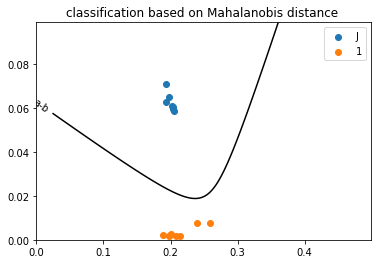

In [7]:
classifer_MD(1,0,True)
classifer_MD_find_line()